### Here we study the photometry noise based on the NSA catalog.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import kuaizi
import torch
import corner

In [3]:
kuaizi.set_matplotlib(style='nature', usetex=False)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import flux2mag, mag2flux, sigma_flux2mag, sigma_mag2flux

In [5]:
nsa_cat = Table.read('./reference_catalog/nsa_v1_0_1.fits')

In [6]:
nsa_cat = nsa_cat[(nsa_cat['Z'] <= 0.13) & (nsa_cat['Z'] >= 0.01)]

In [7]:
flux_nsa = nsa_cat['ELPETRO_NMGY'][:,2:]
ivar_nsa = nsa_cat['ELPETRO_NMGY_IVAR'][:,2:]

zred_nsa = nsa_cat['Z']

mags_nsa = flux2mag(flux_nsa).data.data
sigs_nsa = sigma_flux2mag(ivar_nsa**-0.5, flux_nsa).data.data

snrs_nsa = flux_nsa.data.data * ivar_nsa.data.data**0.5

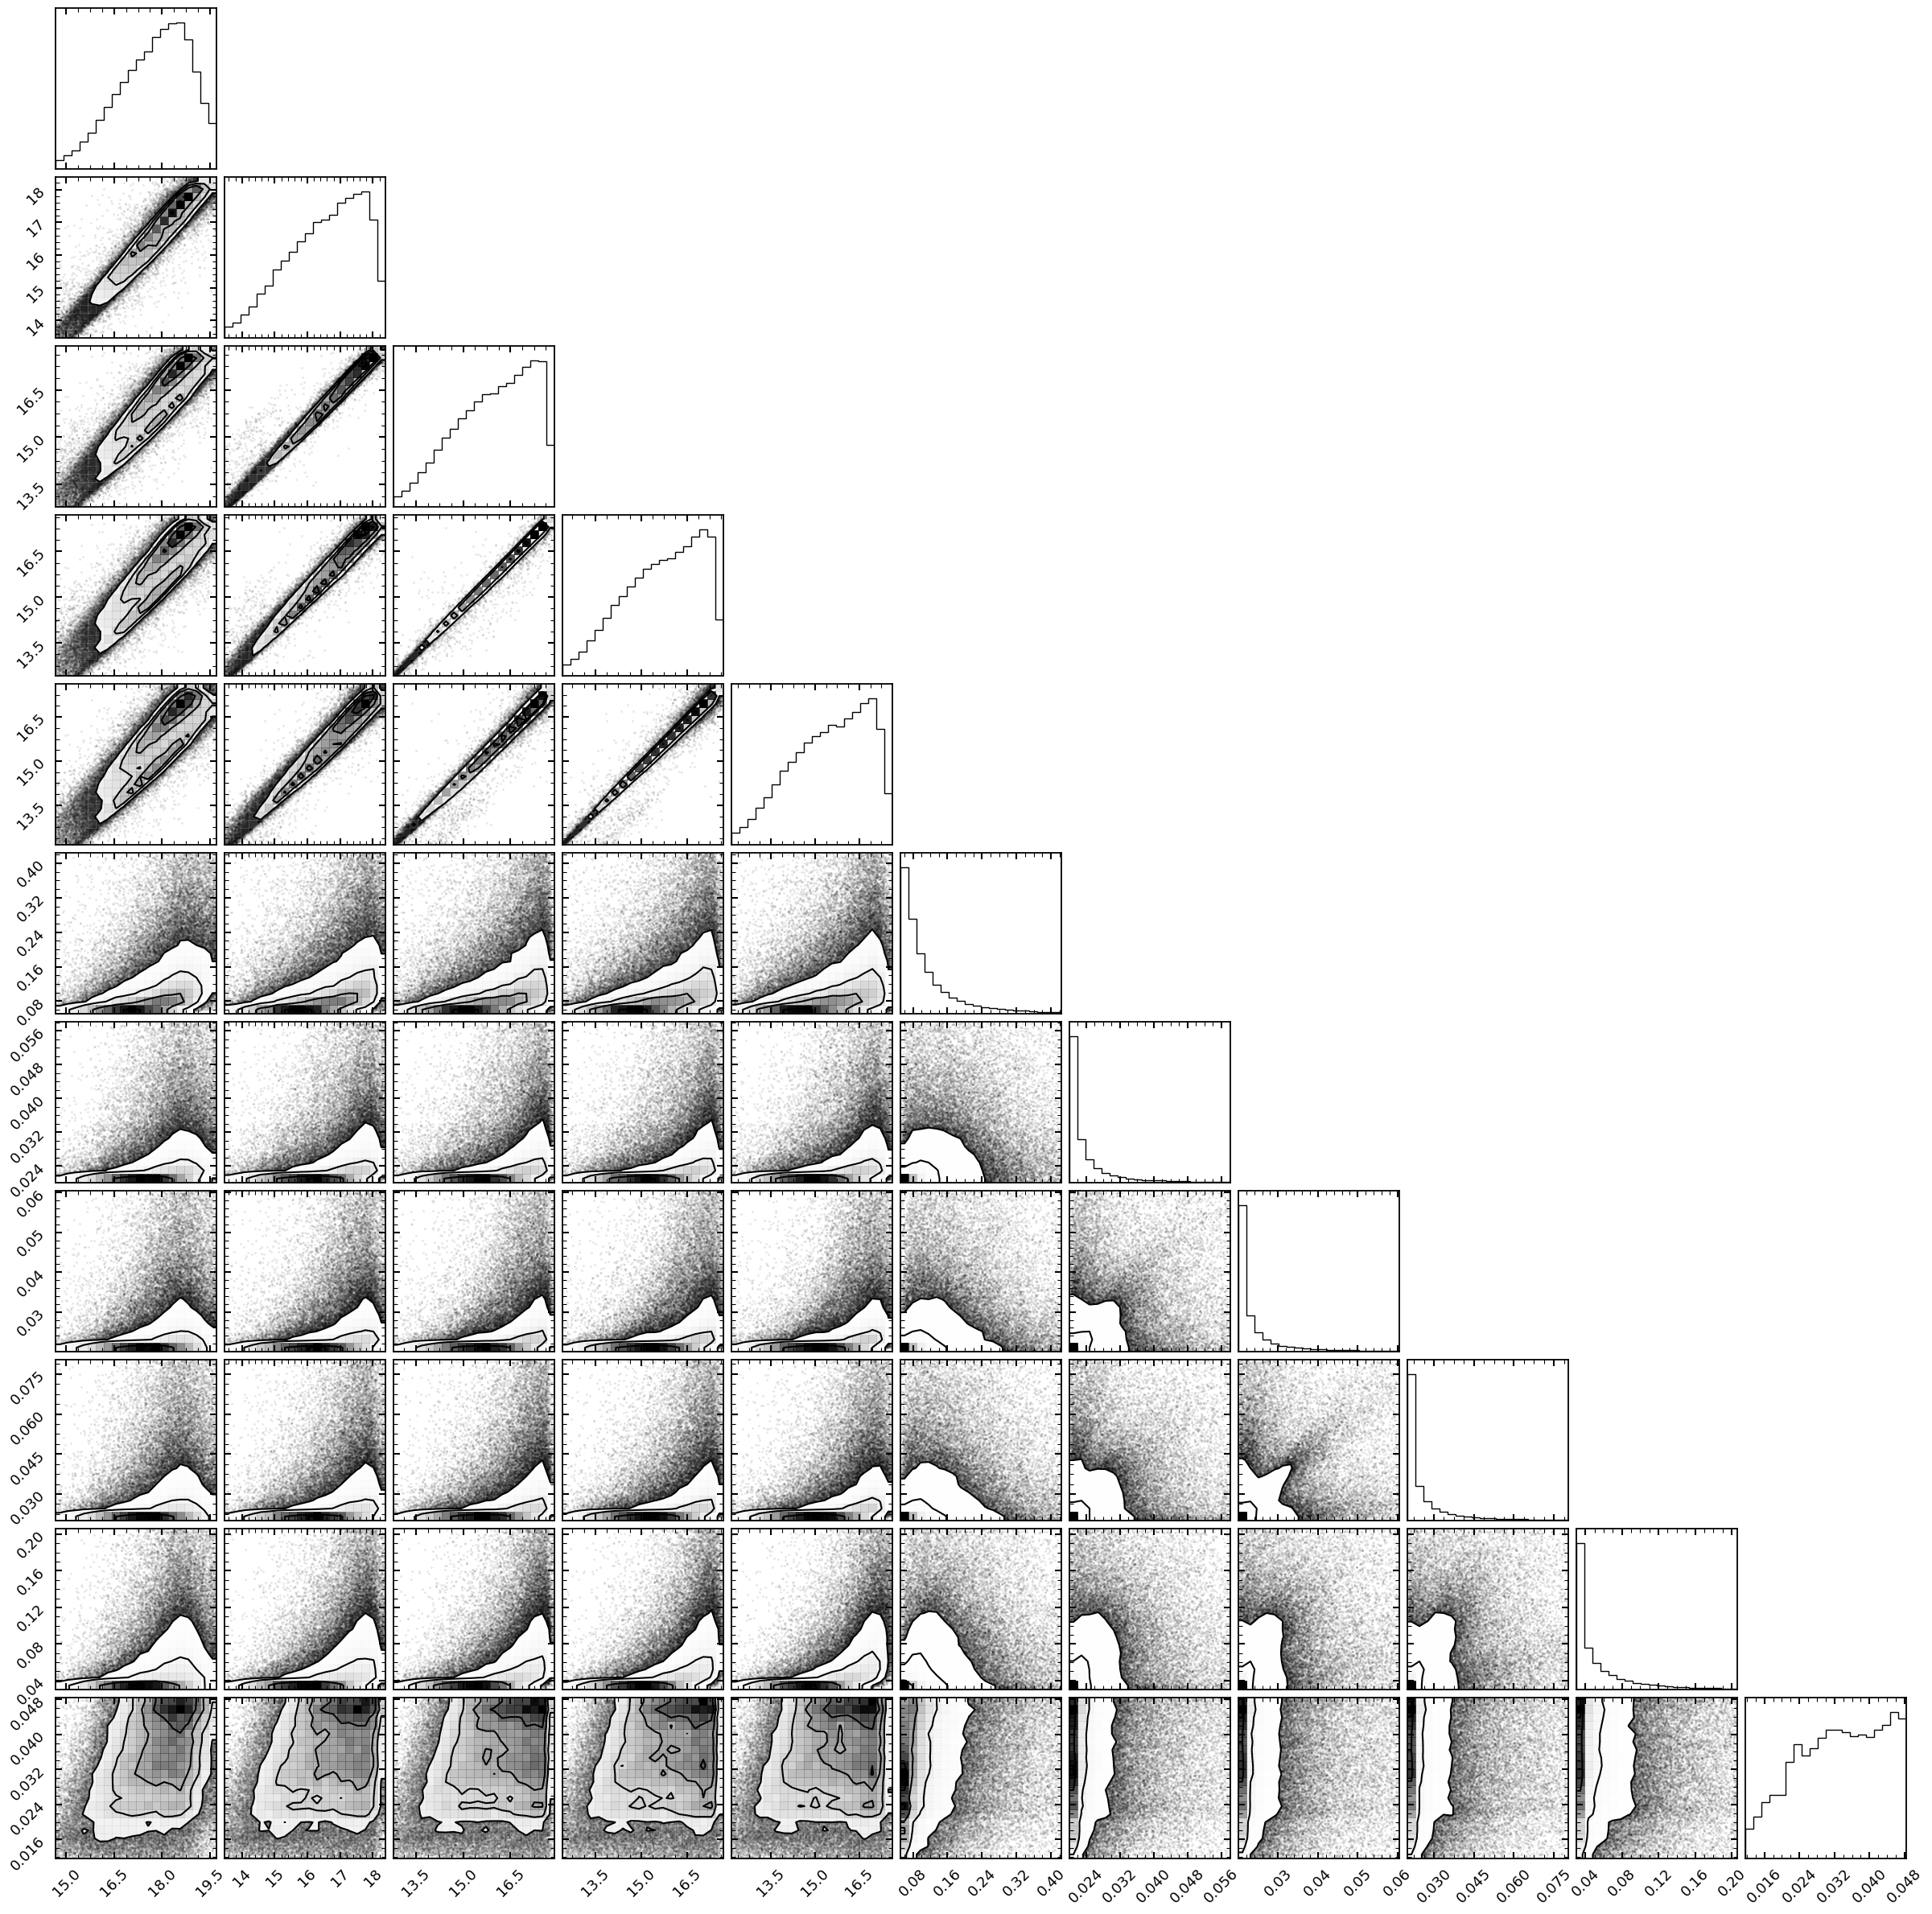

In [50]:
fig = corner.corner(np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), 
                    range=np.nanquantile(
                     np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), 
                     [0.01, 0.95], axis=0).T)

In [8]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [13]:
def trimmed_median(x): 
    xlim = np.quantile(x, [0.0, 0.9])
    return np.median(x[(x > xlim[0]) & (x < xlim[1])])

def trimmed_std(x): 
    xlim = np.quantile(x, [0.0, 0.9])
    return np.std(x[(x > xlim[0]) & (x < xlim[1])])

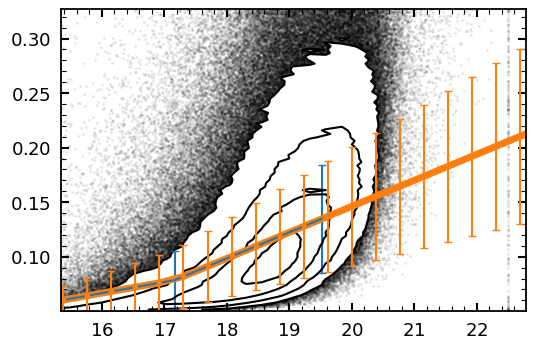

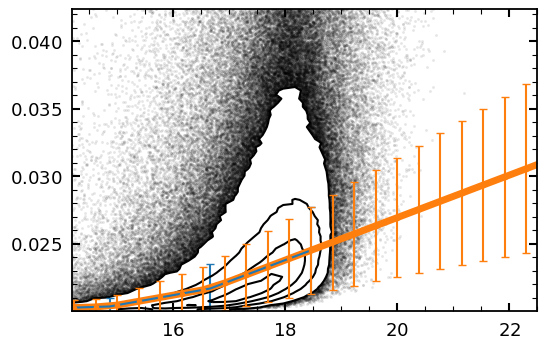

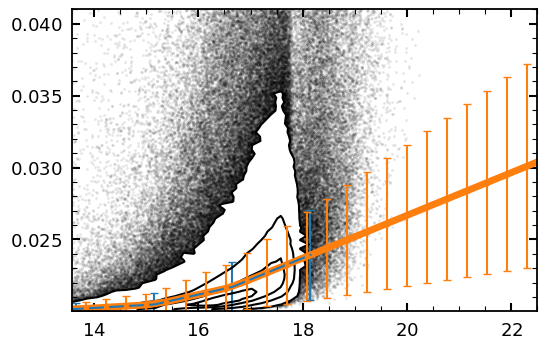

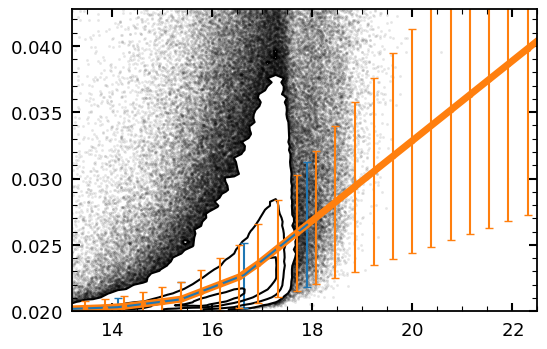

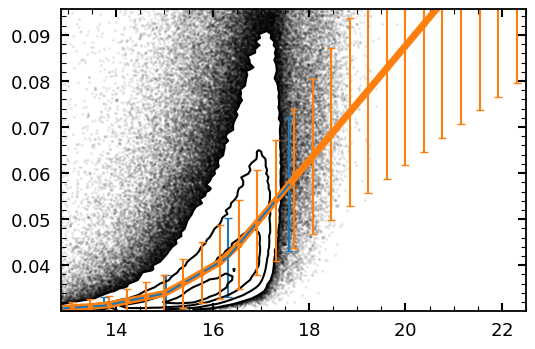

In [18]:
meds_sigs, stds_sigs = [], [] 

for i in range(5): 
    clean = (np.isfinite(mags_nsa[:,i]) & (sigs_nsa[:,i] < np.max([np.quantile(sigs_nsa[:,i], 0.9), 0.05])))

    med_sig, mags_edges, _ = binned_statistic(mags_nsa[clean,i], sigs_nsa[clean,i], statistic=trimmed_median, range=np.nanquantile(mags_nsa[clean,i], [0., 0.995]), bins=10)
    std_sig, mags_edges, _ = binned_statistic(mags_nsa[clean,i], sigs_nsa[clean,i], statistic=trimmed_std, range=np.nanquantile(mags_nsa[clean,i], [0., 0.995]), bins=10)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    corner.hist2d(mags_nsa[clean,i], sigs_nsa[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 25, 40)), fmt='.C1')
    sub.set_xlim(np.nanquantile(mags_nsa[clean,i], [0.01, 1.]))
    sub.set_ylim(np.nanquantile(sigs_nsa[clean,i], [0.0, 0.975]))

In [19]:
np.save('./noise_model/nsa_noise_model_mag.npy', np.vstack([meds_sigs, stds_sigs]))

In [12]:
del nsa_cat

In [ ]:
from torch.nn import MSELoss

In [56]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)
speculator.network.eval();

In [105]:
with open(f'./nde_theta_SNR10_new/nde_theta_best_loss_nsf_368.pkl', 'rb') as f:
    NDE_theta = pickle.load(f)
samples = NDE_theta.best_model.sample(5000)
mags_clean = speculator._predict_mag_with_mass_redshift(samples, noise=False, SNR=20)#.cpu().detach().numpy()

In [106]:
mags = speculator._predict_mag_with_mass_redshift(samples,
                                    noise='nsa', 
                                    noise_model_dir='./noise_model/nsa_noise_model_mag.npy')#.cpu().detach().numpy()

In [107]:
loss_fn = MSELoss()
loss = loss_fn(mags, mags_clean)

In [108]:
loss.backward()

In [109]:
mags

tensor([[21.4219, 20.1522, 19.5430, 19.0891, 18.8647],
        [20.7186, 19.6317, 19.2555, 18.9356, 18.8836],
        [19.4939, 18.5819, 18.0950, 17.7835, 17.9754],
        ...,
        [19.0482, 18.0547, 17.6160, 17.3525, 17.0328],
        [19.4877, 18.0336, 17.2858, 16.9353, 16.6348],
        [22.7741, 21.1600, 20.2396, 19.7317, 19.1256]], device='cuda:0',
       grad_fn=<MulBackward0>)

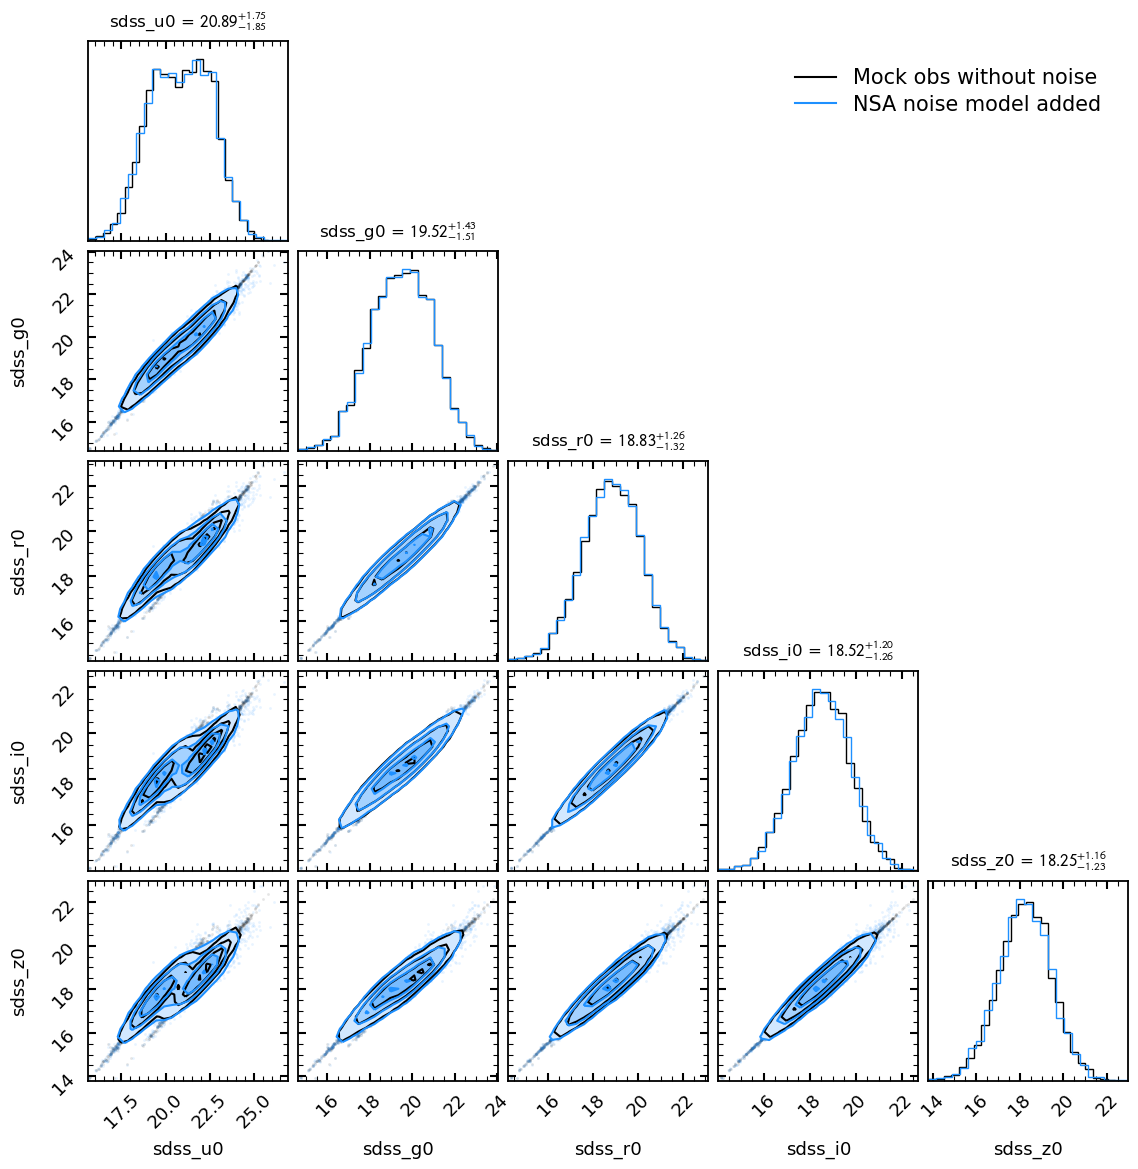

In [82]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label=r'Mock obs without noise')
b_line = mlines.Line2D([], [], color='dodgerblue', label='NSA noise model added')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(mags_clean.cpu().detach().numpy(),
                       color='k', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


nf_plot = corner.corner(mags.cpu().detach().numpy(), 
                        fig=figure, labels=labels, bins=25,
                        color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                        smooth=0.7, fill_contours=True,
                        show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))